# Import Library

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize_scalar

# import os
# from fredapi import Fred

# import marketobserve as mo

In [2]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options
    # print(exps[1])
    # Get options for each expiration
    options = pd.DataFrame()
    options_list = []
    for e in exps:
        opt = tk.option_chain(e)
        calls_puts = pd.concat([opt.calls, opt.puts])
        calls_puts['expirationDate'] = e
        options_list.append(calls_puts)
    
    # Combine all options data
    options = pd.concat(options_list, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + dt.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - dt.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

In [3]:
# options_chain("^GSPC")
# options_chain("^HSI")

# Monthly Return Distribution

In [4]:
def yf_download(ticker, start_date, end_date, frequency='1d', progress=True, auto_adjust=False):
    """
    Download stock data from Yahoo Finance
    
    Parameters:
    - ticker: Stock symbol (e.g., "^HSI")
    - start_date: datetime.date or string in YYYY-MM-DD format
    - end_date: datetime.date or string in YYYY-MM-DD format
    - frequency: Data frequency ('1d', '1wk', '1mo')
    - progress: Show download progress bar
    - auto_adjust: Adjust all OHLC automatically
    
    Returns:
    - DataFrame with stock data
    """
    df = yf.download(
        ticker, 
        start=start_date, 
        end=end_date,
        interval=frequency,
        progress=progress, 
        auto_adjust=auto_adjust
    )
    df.columns = df.columns.droplevel(1)
    df.set_index(pd.DatetimeIndex(df.index), inplace=True)
    # Reorder columns as specified
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return df

# Example usage:
start = dt.date(1900, 1, 1)
end = dt.date(2026, 1, 1)
ticker = "^HSI"
data = yf_download(ticker, start, end)
# data.index = data.index.strftime('%Y-%m')
# data.to_excel(f"{ticker}.xlsx")


# download data from local file
# data = pd.read_excel("spx.xlsx",index_col="Date")
# data.columns = ["Close"]
# data = data.sort_index(ascending=True)

# # download data from xbbg
# from xbbg import blp
# data = blp.bdh("SPX Index","PX_LAST","1900-01-01") # HSI, NKY, SPX
# data.columns = ["Close"]
# data = data.sort_index(ascending=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
# data
data.describe()

Price,Open,High,Low,Close,Adj Close,Volume
count,9443.000000,9443.000000,9443.000000,9443.000000,9443.000000,9.443000e+03
mean,15730.339830,15835.069275,15607.383427,15724.356797,15724.356797,1.015611e+09
std,7934.822403,7978.216794,7875.977179,7927.229649,7927.229649,1.151744e+09
min,1950.500000,1950.500000,1894.900024,1894.900024,1894.900024,0.000000e+00
25%,9632.895020,9696.700195,9553.189941,9632.399902,9632.399902,0.000000e+00
50%,15747.400391,15851.509766,15611.549805,15738.799805,15738.799805,4.226760e+08
75%,22478.184570,22590.524414,22302.814453,22455.929688,22455.929688,1.788388e+09
max,33335.480469,33484.078125,32897.039062,33154.121094,33154.121094,1.125790e+10


In [6]:
def create_data_sources(df, periods, all_period_start, frequency):
    """
    创建不同时间周期的数据来源
    """
    current_date = pd.Timestamp.now()

    # 根据 frequency 筛选数据到本周/本月/本季度的第一天
    if frequency == 'ME':
        end_date = current_date.replace(day=1)
    elif frequency == 'W':
        end_date = current_date - pd.DateOffset(days=current_date.weekday())
    elif frequency == 'QE':
        end_date = current_date - pd.tseries.offsets.QuarterBegin()
    else:
        raise ValueError("Invalid frequency value. Allowed values are 'ME', 'W', 'QE'.")

    df = df[df.index < end_date]
    last_date = df.index[-1]

    if all_period_start is None:
        all_period_start = "2010-01-01"

    data_sources = {}
    for period in periods:
        if isinstance(period, int):
            if frequency in ['ME', 'W']:
                start_date = last_date - pd.DateOffset(months=period - 1)
            elif frequency == 'QE':
                start_date = last_date - pd.DateOffset(quarters=period - 1)
            col_name = f"{start_date.strftime('%y%b')}-{last_date.strftime('%y%b')}"
            data_sources[col_name] = df.loc[df.index >= start_date]
        elif period == "ALL":
            col_name = f"{pd.to_datetime(all_period_start).strftime('%y%b')}-{last_date.strftime('%y%b')}"
            data_sources[col_name] = df.loc[df.index >= all_period_start]
        else:
            raise ValueError("Invalid period value")

    return data_sources


def refrequency(df, frequency: str):
    """
    对数据进行重采样
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")
    if not {'Open', 'High', 'Low', 'Close'}.issubset(df.columns):
        raise ValueError("DataFrame must contain OHLC columns")

    try:
        refrequency_df = df.resample(frequency).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        }).dropna()

    except KeyError as e:
        import logging
        logging.error(f"Missing column {e} in DataFrame")
        raise ValueError(f"Error processing data: Missing column {e}")
    except Exception as e:
        import logging
        logging.error(f"Unexpected error: {str(e)}")
        raise ValueError(f"Error processing data: {str(e)}")


    return refrequency_df


def oscillation(df):
    """
    计算震荡指标
    """
    data = df[['Open', 'High', 'Low', 'Close']].copy()
    data['LastClose'] = data["Close"].shift(1)
    data["Oscillation"] = data["High"] - data["Low"]
    data["OscillationPct"] = data["Oscillation"] / data['LastClose'] * 100
    data = data.dropna()
    return data


def tail_stats(df, feature, frequency, periods: list = [12, 36, 60, "ALL"], all_period_start: str = None, interpolation: str = "linear"):
    """
    计算不同时间周期的统计指标
    """
    if not isinstance(periods, list):
        raise TypeError("periods must be a list")
    if not all(isinstance(p, (int, str)) for p in periods):
        raise ValueError("periods must contain integers or strings")

    data_sources = create_data_sources(df, periods, all_period_start, frequency)

    stats_index = pd.Index(["mean", "std", "skew", "kurt", "max", "99th", "95th", "90th"])
    stats_df = pd.DataFrame(index=stats_index)

    for period_name, data in data_sources.items():
        stats_df[period_name] = [
            data[feature].mean(),
            data[feature].std(),
            data[feature].skew(),
            data[feature].kurtosis(),
            data[feature].max(),
            data[feature].quantile(0.99, interpolation=interpolation),
            data[feature].quantile(0.95, interpolation=interpolation),
            data[feature].quantile(0.90, interpolation=interpolation)
        ]

    return stats_df


def tail_plot(df, feature, frequency, periods: list = [12, 36, 60, "ALL"], all_period_start: str = None, interpolation: str = "linear"):
    """
    绘制不同时间周期的特征值分布
    """
    data_sources = create_data_sources(df, periods, all_period_start, frequency)

    if frequency == "ME":
        bin_range = list(range(0, 35, 5))
    elif frequency == "W":
        bin_range = list(range(0, 18, 3))


    for period_name, data in data_sources.items():
        plt.figure(figsize=(10, 6))
        sns.set_style("darkgrid")
        n, bins, patches = plt.hist(data[feature], bins=bin_range, alpha=0.5, color='skyblue', density=True, cumulative=True)

        n_diff = np.insert(np.diff(n), 0, n[0])
        for rect, h_diff, h in zip(patches, n_diff, n):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, f'{h_diff * 100:.0f}%/{h * 100:.0f}%', ha='center', va='bottom', size=12)

        percentiles = [data[feature].quantile(p, interpolation=interpolation) for p in [0.90, 0.95, 0.99]]
        for p, val in zip([90, 95, 99], percentiles):
            plt.axvline(val, color='red', linestyle=':', alpha=0.3, label=f'{p}th: {val:.1f}%')

        last_three = data[feature].iloc[-3:]
        last_three_dates = last_three.index.strftime('%Y%b')
        for val, date, grayscale in zip(last_three, last_three_dates, np.arange(0.7, 0, -0.3)):
            plt.scatter(val, 0, color=str(grayscale), s=100, zorder=5, label=f'{date}: {val:.1f}%')

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"Distribution of {feature} - {period_name}")
        plt.xlabel(f"{feature} (%)")
        plt.ylabel("Density")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()



def calculate_projections(data, feature, percentile, interpolation, bias_weight):
    data["ProjectHigh"] = data["LastClose"] + data["LastClose"] * data[feature].quantile(percentile, interpolation=interpolation) / 100 * bias_weight
    data["ProjectLow"] = data["LastClose"] - data["LastClose"] * data[feature].quantile(percentile, interpolation=interpolation) / 100 * (1 - bias_weight)
    data["ActualClosingStatus"] = np.where(data["Close"] > data["ProjectHigh"], 1, 
                                       np.where(data["Close"] < data["ProjectLow"], -1, 0))
    realized_bias = ((data["ActualClosingStatus"] == 1).sum() - ((data["ActualClosingStatus"] == -1).sum())) / len(data)
    
    return realized_bias

def volatility_projection(df, feature, frequency: str = 'ME', percentile: float = 0.90, prefer_bias: float = None, periods: list = [12, 36, 60, "ALL"], all_period_start: str = None, interpolation: str = "linear"):
    """
    计算不同时间周期的波动率预测
    """
    if not isinstance(periods, list):
        raise TypeError("periods must be a list")
    if not all(isinstance(p, (int, str)) for p in periods):
        raise ValueError("periods must contain integers or strings")

    if feature == "OscillationPct":
        refrequency_data = refrequency(df, frequency=frequency)
        refrequency_feature = oscillation(refrequency_data)

        data_sources = create_data_sources(refrequency_feature, periods, all_period_start, frequency)

        volatility_projection_index = pd.Index([f"{refrequency_feature.index[-2].strftime('%y%b%d')}", f"{percentile}th {feature}", "RealizedBias%",  "ProjectedHighWeight%", "ProjHigh", "ProjLow", f"{df.index[-1].strftime('%y%b%d')}"])
        volatility_projection_df = pd.DataFrame(index=volatility_projection_index)

        for period_name, data in data_sources.items():
            period_end_close = data["Close"].iloc[-1]
            assumed_volatility = data[feature].quantile(percentile, interpolation=interpolation)

            if prefer_bias is not None:
                # 寻找最佳 bias_weight 的逻辑
                proj_high_weights = np.linspace(0.1, 0.9, 90)  # 在 0 到 1 之间生成 100 个等间距的 bias_weight 值
                min_error = float('inf')
                best_proj_high_weight = 0
                for proj_high_weight in proj_high_weights:
                    realized_bias = calculate_projections(data.copy(), feature, percentile, interpolation, proj_high_weight)
                    error = abs(realized_bias - prefer_bias)
                    if error < min_error:
                        min_error = error
                        best_proj_high_weight = proj_high_weight
                proj_high_weight = best_proj_high_weight            
            
            else:
                proj_high_weight = 0.5

            realized_bias = calculate_projections(data, feature, percentile, interpolation, proj_high_weight)

            proj_high = period_end_close + period_end_close * assumed_volatility / 100 * proj_high_weight
            proj_low = period_end_close - period_end_close * assumed_volatility / 100 * (1 - proj_high_weight)
            
            last_close = df["Close"].iloc[-1]

            volatility_projection_df[period_name] = [
                period_end_close,
                assumed_volatility,
                realized_bias*100,
                proj_high_weight*100,
                proj_high,
                proj_low,
                last_close
            ]
        return volatility_projection_df
    else:
        raise ValueError("Invalid feature value")

      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
mean    12.313264    11.620305    10.624801     8.702514
std      5.664372     4.991020     4.594926     4.185374
skew     1.462606     1.492488     1.576732     1.669566
kurt     1.478621     1.965495     2.826794     3.520292
max     25.151220    25.773981    25.773981    25.773981
99th    24.729713    25.556015    25.406552    23.647201
95th    23.043685    22.277308    20.740696    17.103455
90th    20.732043    18.941766    15.619080    13.787060 



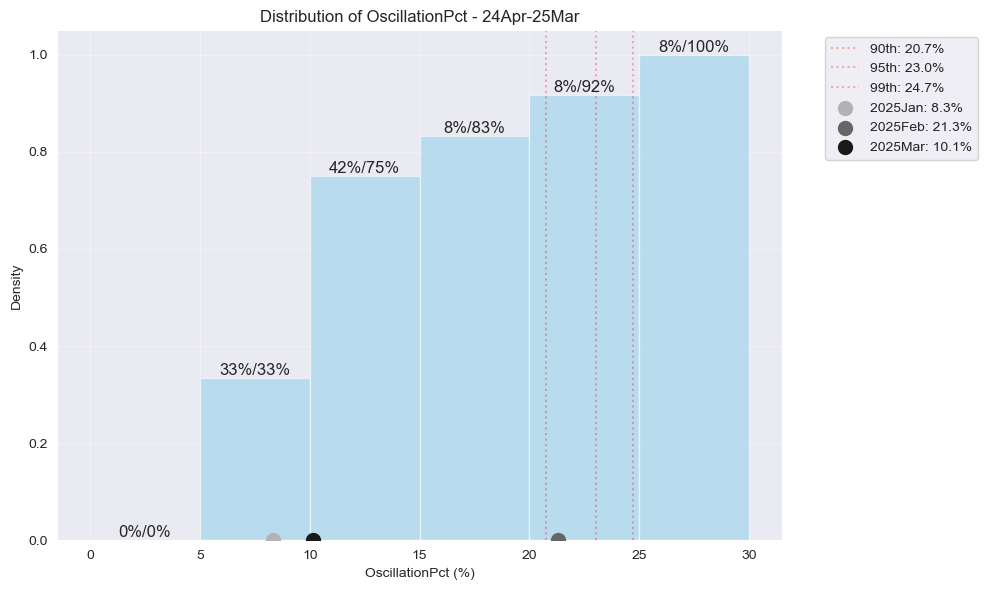

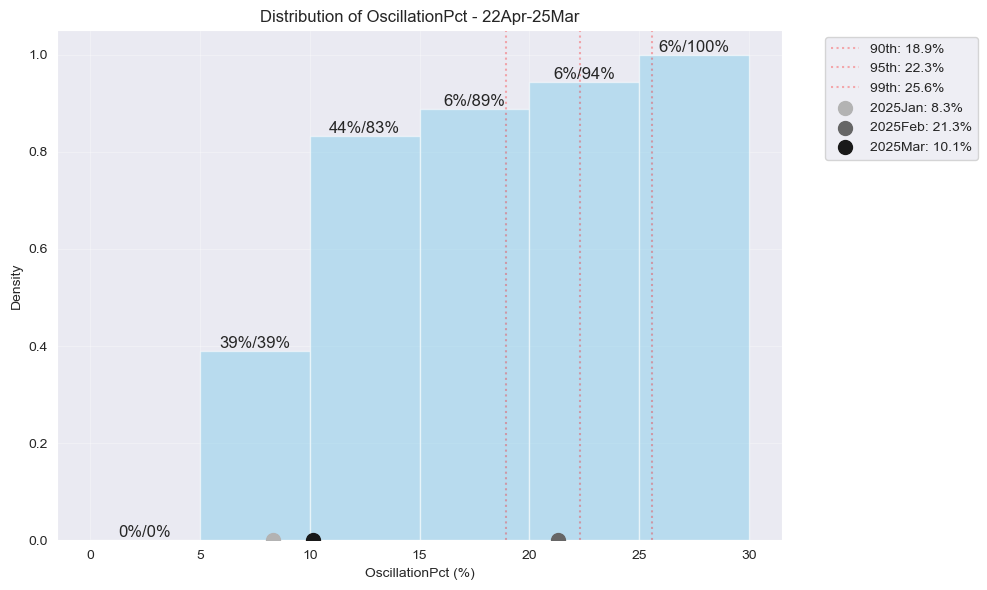

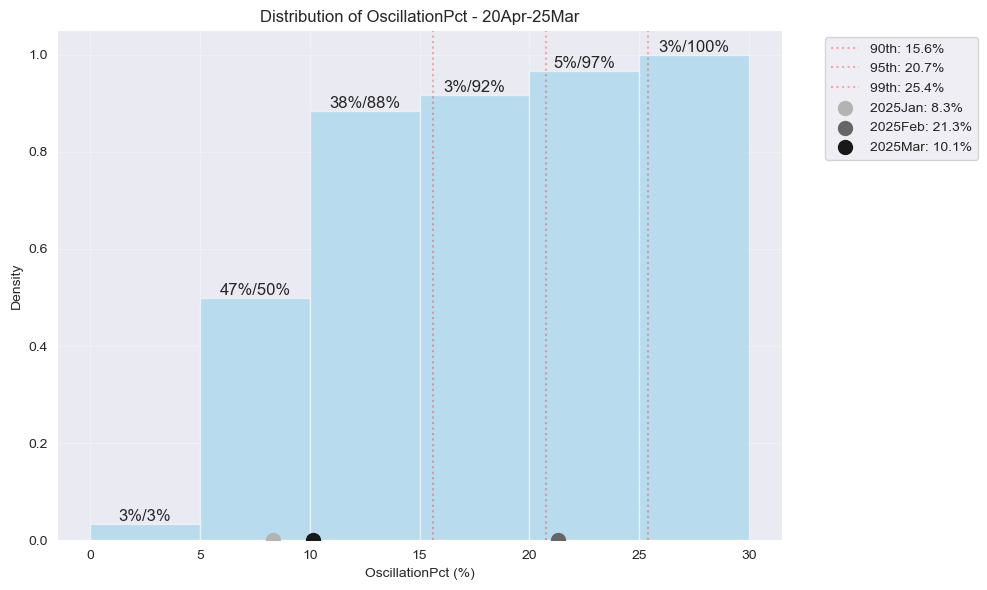

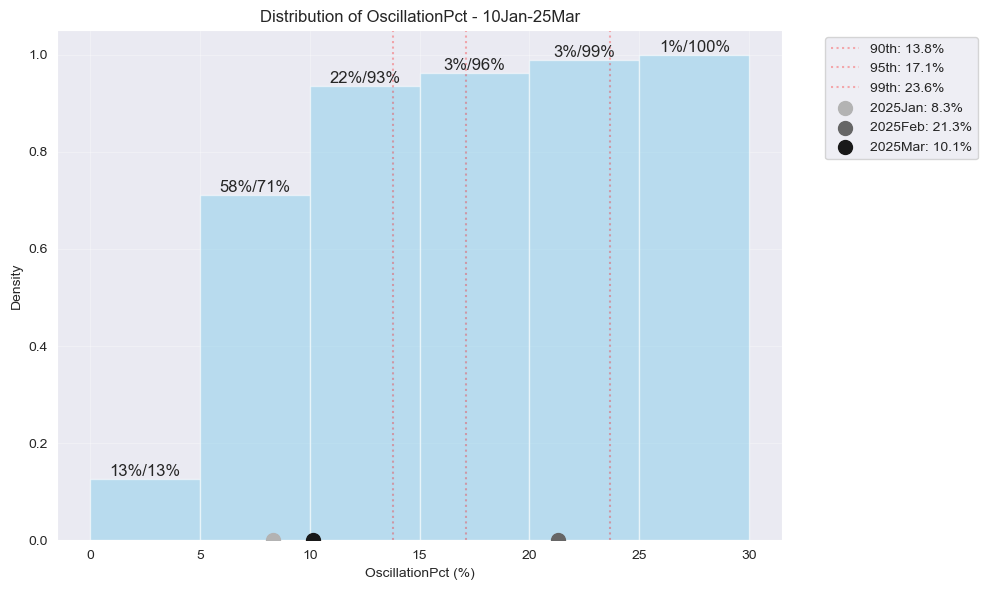

                      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
25Mar31                   23119.6      23119.6      23119.6      23119.6
0.9th OscillationPct         20.7         18.9         15.6         13.8
RealizedBias%                16.7          5.6         -3.3         -3.3
ProjectedHighWeight%         50.0         50.0         50.0         50.0
ProjHigh                  25516.2      25309.2      24925.1      24713.3
ProjLow                   20723.0      20930.0      21314.0      21525.8
25Apr03                   22849.8      22849.8      22849.8      22849.8 

                      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
25Mar31                   23119.6      23119.6      23119.6      23119.6
0.9th OscillationPct         20.7         18.9         15.6         13.8
RealizedBias%                 0.0          0.0          0.0          0.5
ProjectedHighWeight%         79.2         52.2         46.0         46.0
ProjHigh                  26916.4      25407.6   

In [7]:
frequency = 'ME'
monthly_data = refrequency(data, frequency=frequency)
monthly_oscill = oscillation(monthly_data)
monthly_tail_stats_result =tail_stats(monthly_oscill,"OscillationPct",frequency=frequency)
print(monthly_tail_stats_result,"\n")

round_digit = 1
tail_plot(monthly_oscill,"OscillationPct",frequency=frequency)
volatility_proj_pbn = volatility_projection(data,"OscillationPct",frequency=frequency,prefer_bias=None).round(round_digit)
print(volatility_proj_pbn,"\n")
volatility_proj_pb0 = volatility_projection(data,"OscillationPct",frequency=frequency,prefer_bias=0).round(round_digit)
print(volatility_proj_pb0)


      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
mean     4.756049     4.775681     4.487392     3.668018
std      2.574099     2.208083     2.098949     1.896477
skew     1.896050     1.873225     2.228325     2.033295
kurt     4.493784     4.854590     8.069084     7.243726
max     13.859898    13.859898    16.593874    16.593874
99th    13.652987    13.543815    13.533469    10.380594
95th     9.388461     8.982476     7.598381     6.902241
90th     6.992733     7.148386     6.606538     5.989943 



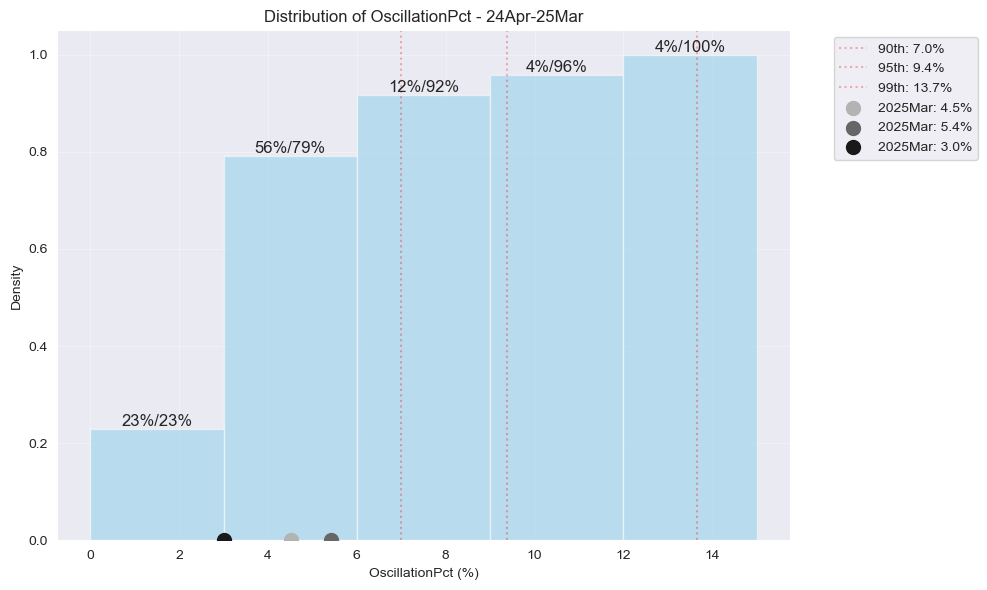

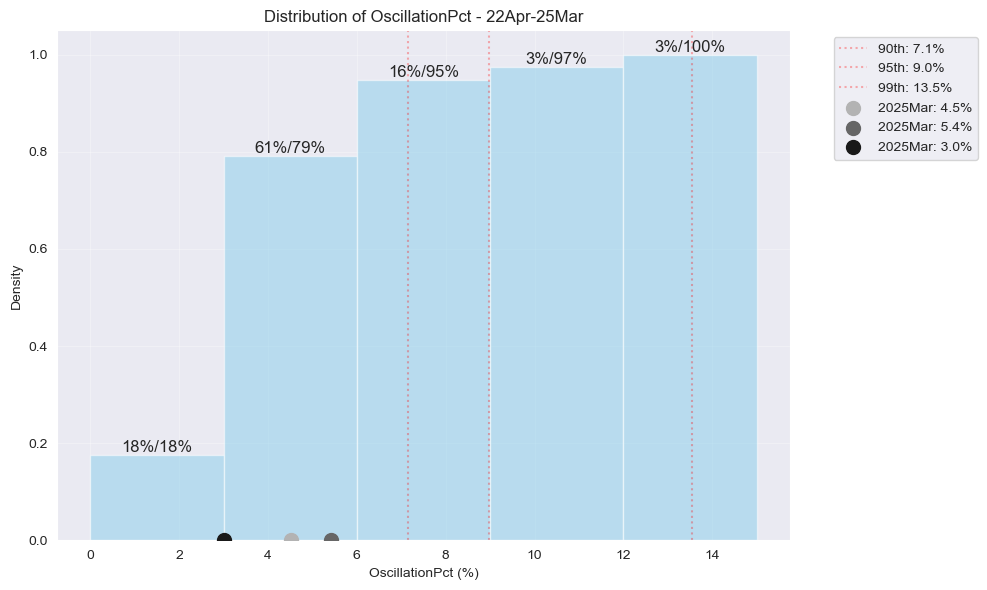

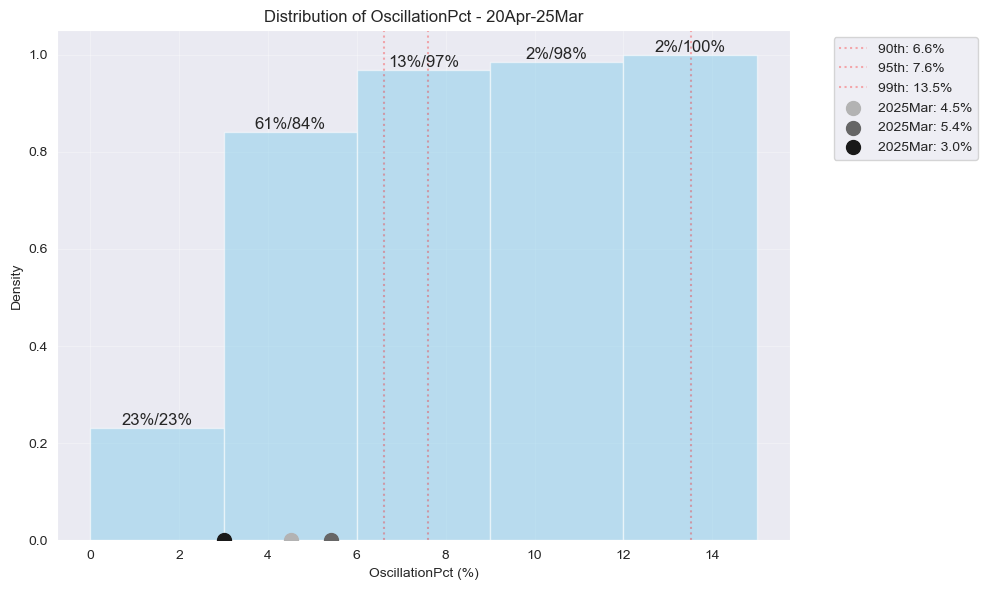

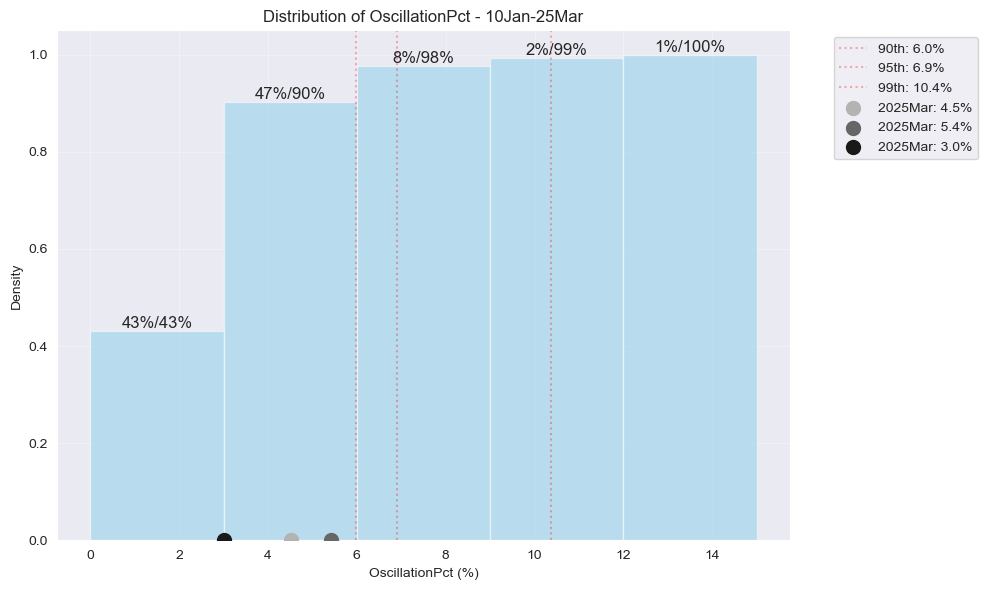

                      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
25Mar30                   23426.6      23426.6      23426.6      23426.6
0.9th OscillationPct          7.0          7.1          6.6          6.0
RealizedBias%                 6.2          2.0         -2.3         -1.0
ProjectedHighWeight%         50.0         50.0         50.0         50.0
ProjHigh                  24245.7      24263.9      24200.4      24128.2
ProjLow                   22607.5      22589.3      22652.8      22725.0
25Apr03                   22849.8      22849.8      22849.8      22849.8 

                      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
25Mar30                   23426.6      23426.6      23426.6      23426.6
0.9th OscillationPct          7.0          7.1          6.6          6.0
RealizedBias%                 0.0          0.0          0.0         -0.4
ProjectedHighWeight%         59.4         52.2         47.8         49.6
ProjHigh                  24400.3      24301.5   

In [8]:
frequency = 'W'
refrequency_data = refrequency(data, frequency=frequency)
oscill = oscillation(refrequency_data)
tail_stats_result =tail_stats(oscill,"OscillationPct",frequency=frequency)
print(tail_stats_result,"\n")

round_digit = 1
tail_plot(oscill,"OscillationPct",frequency=frequency)
volatility_proj_pbn = volatility_projection(data,"OscillationPct",frequency=frequency,prefer_bias=None).round(round_digit)
print(volatility_proj_pbn,"\n")
volatility_proj_pb0 = volatility_projection(data,"OscillationPct",frequency=frequency,prefer_bias=0).round(round_digit)
print(volatility_proj_pb0)


In [9]:
# test
# mo.ChangeDistPlot(data, time_windows=['1Y', ('20240101', '20250401'), '100Y'], frequencies = ['W', 'M'])